In [1]:
import os
from typing import Tuple, Union, List, Dict
from pathlib import Path
import xml.etree.ElementTree as ET
import glob

from tqdm import tqdm

import time

import numpy as np
import pandas as pd

from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
# import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.utils import draw_bounding_boxes
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

## Hard Variables

In [2]:
DATA_PATH = './../data/'
IMAGES_FOLDER = 'images/'
ANNOTATIONS_FOLDER = 'annotations/'

LABELS_TO_IDX = {
    'cat':0,
    'dog':1
}

NUMBER_CLASSES = len(LABELS_TO_IDX)

TRANSFORM = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 16
NUM_WORKERS = 1
EPOCHS=10

LEARNING_RATE=0.01

# DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # MPS give an error
DEVICE = "cpu"

## Dataset

In [3]:
class DogVSCatObjectDetectionDataset(Dataset):
    def __init__(
        self,
        images_path:Path,
        annotations_path:Path,
        class_to_idx_mapping:Dict,
        transform:transforms.Compose=None
        ) -> None:
        
        super().__init__()
        self.images_path = images_path
        
        self.annotations_path = annotations_path
        self.annotations = glob.glob(
            os.path.join(
                annotations_path,
                '*.xml'
            )
        )
        
        self.class_to_idx_mapping = class_to_idx_mapping
        self.classes = list(class_to_idx_mapping.keys())
        self.idx_to_classes_mapping = {value:key for key, value in class_to_idx_mapping.items()}
        
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.annotations)
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img_path = os.path.join(
            self.images_path,
            os.path.basename(self.annotations[index]).split('.')[0] + '.png'
        )
        annotation_path = self.annotations[index]
        
        image = Image.open(img_path).convert('RGB')
        targets = self._read_xml_file(annotation_path)        
        
        if self.transform:
            image = self.transform(image)
            
        return image, targets
    
    def _read_xml_file(self, file:Path) -> Dict:
        targets = {}
        boxes = []
        labels = []
        
        root = ET.parse(file).getroot()
        
        for obj in root.findall('object'):
            label = self.class_to_idx_mapping[obj.find('name').text]
            labels.append(label)
            
            object_bndbox = obj.find('bndbox')
            
            xmin = int(object_bndbox.find('xmin').text)
            ymin = int(object_bndbox.find('ymin').text)
            xmax = int(object_bndbox.find('xmax').text)
            ymax = int(object_bndbox.find('ymax').text)
            
            boxes.append([xmin, ymin, xmax, ymax])
        
        targets['boxes'] = torch.tensor(boxes, dtype=torch.float32)
        targets['labels'] = torch.tensor(labels, dtype=torch.int64)
            
        return targets

In [4]:
train_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(
        DATA_PATH,
        'train',
        IMAGES_FOLDER
    ),
    annotations_path=os.path.join(
        DATA_PATH,
        'train',
        ANNOTATIONS_FOLDER
    ),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM
)

test_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(
        DATA_PATH,
        'test',
        IMAGES_FOLDER
    ),
    annotations_path=os.path.join(
        DATA_PATH,
        'test',
        ANNOTATIONS_FOLDER
    ),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=NUM_WORKERS,
    collate_fn=lambda batch: tuple(zip(*batch))
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=NUM_WORKERS,
    collate_fn=lambda batch: tuple(zip(*batch))
)

### Validate dataset

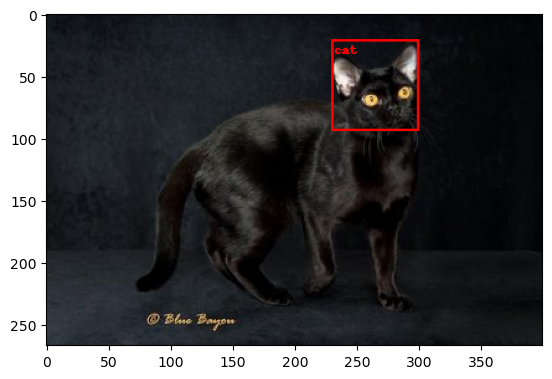

In [5]:
def imshow_with_box(img, boxes, labels, **kwargs):
    img_int = (img.clone().detach() *255).to(torch.uint8)
    
    plt.imshow(
        draw_bounding_boxes(
            image=img_int, 
            boxes=boxes,
            labels=labels,
            **kwargs
        ).permute(1, 2, 0)
    )

img, targets = train_dataset[np.random.randint(0, len(train_dataset))]

imshow_with_box(
    img=img,
    boxes=targets['boxes'],
    labels=[train_dataset.classes[i] for i in targets['labels']],
    colors='red',
    width=2
)

In [6]:
da

NameError: name 'da' is not defined

## Model

In [ ]:
def create_fasterrcnn_mobilenet_v3_large_model(num_classes):
    weights = models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    return model

model = create_fasterrcnn_mobilenet_v3_large_model(NUMBER_CLASSES)

## Train model

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Dict:
    """
    Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
        Dict: loss_total, loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg
    """
    model.train()

    all_losses_dict = []

    for X, y in tqdm(dataloader, desc='train', leave=False):
        X = list(image.to(device) for image in X)
        y = [{k: v.clone().detach().to(device) for k, v in target.items()} for target in y]

        loss_dict = model(X, y)
        
        total_loss = sum(loss for loss in loss_dict.values())
        
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_dict_append['loss_total'] = total_loss.item()
        all_losses_dict.append(loss_dict_append)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return pd.DataFrame(all_losses_dict).mean().to_dict()


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    metric: MeanAveragePrecision=None,
) -> MeanAveragePrecision:
    """
    Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
        model: A PyTorch model to be tested.
        dataloader: A DataLoader instance for the model to be tested on.
        metric: MeanAveragePrecision to compute the metrics
        device: A target device to compute on (e.g. "cuda" or "cpu").
        
    Returns:
        MeanAveragePrecision
    """
    model.eval()
    
    metric = MeanAveragePrecision() if not metric else metric

    with torch.inference_mode():
        for X, y in X, y in tqdm(dataloader, desc='test', leave=False):
            X = list(image.to(device) for image in X)
            y = [{k: torch.tensor(v).to(device) for k, v in target.items()} for target in y]

            preds = model(X)
            
            metric.update(preds, y)

    return metric


In [ ]:
def train(
    model: torch.nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    test_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device, 
    # writer: torch.utils.tensorboard.writer.SummaryWriter 
) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    
    It uses Reduce LR On Plateau regularization based on test loss.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.
    """
    
    results = {
        "train_loss_train": [],
        "train_loss_classifier": [],
        "train_loss_box_reg": [],
        "train_loss_objectness": [],
        "train_loss_rpn_box_reg": [],
        'map': [],
        'map_50': [],
        'map_75': [],
    }
    
    model.to(device)
    
    test_metric = MeanAveragePrecision()

    for epoch in range(epochs):
        train_results = train_step(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        
        test_metric = test_step(
            model=model,
            dataloader=test_dataloader,
            device=device,
            metric=test_metric
        )
        
        test_metrics = test_metric.compute()

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss_train: {train_results['loss_train']:.4f} | "
          f"train_loss_classifier: {train_results['loss_classifier']:.4f} | "
          f"train_loss_box_reg: {train_results['loss_box_reg']:.4f} | "
          f"train_loss_objectness: {train_results['loss_objectness']:.4f} | "
          f"train_loss_rpn_box_reg: {train_results['loss_rpn_box_reg']:.4f} | "
          f"mAP: {test_metrics['map'].item():.4f}"
          f"mAP50: {test_metrics['map_50'].item():.4f}"
          f"mAP70: {test_metrics['map_70'].item():.4f}"
        )

        results["train_loss_train"].append(train_results['loss_train'])
        results["train_loss_classifier"].append(train_results['loss_classifier'])
        results["train_loss_box_reg"].append(train_results['loss_box_reg'])
        results["train_loss_objectness"].append(train_results['loss_objectness'])
        results["train_loss_rpn_box_reg"].append(train_results['loss_rpn_box_reg'])
        results["map"].append(test_metrics['map'].item())
        results["map_50"].append(test_metrics['map_50'].item())
        results["map_70"].append(test_metrics['map_70'].item())

        # if writer:
            # writer.add_scalar(tag="Loss/train", scalar_value=train_loss, global_step=epoch)
            # writer.add_scalar(tag="Loss/test", scalar_value=test_loss, global_step=epoch)
            # writer.add_scalar(tag="Accuracy/train", scalar_value=train_acc, global_step=epoch)
            # writer.add_scalar(tag="Accuracy/test", scalar_value=test_acc, global_step=epoch)
            # writer.add_scalar(tag="AUC/train", scalar_value=train_auc, global_step=epoch)
            # writer.add_scalar(tag="AUC/test", scalar_value=test_auc, global_step=epoch)

            # writer.close()

    return results


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

results = train(
    model=model, 
    train_dataloader=train_loader, 
    test_dataloader=test_loader, 
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE,
)